 Loading Data...
✅ Loaded Baseline Results: 9 rows
 Loaded Hyperparameter Results: 15 rows

 Generating Baseline Comparison Plots...


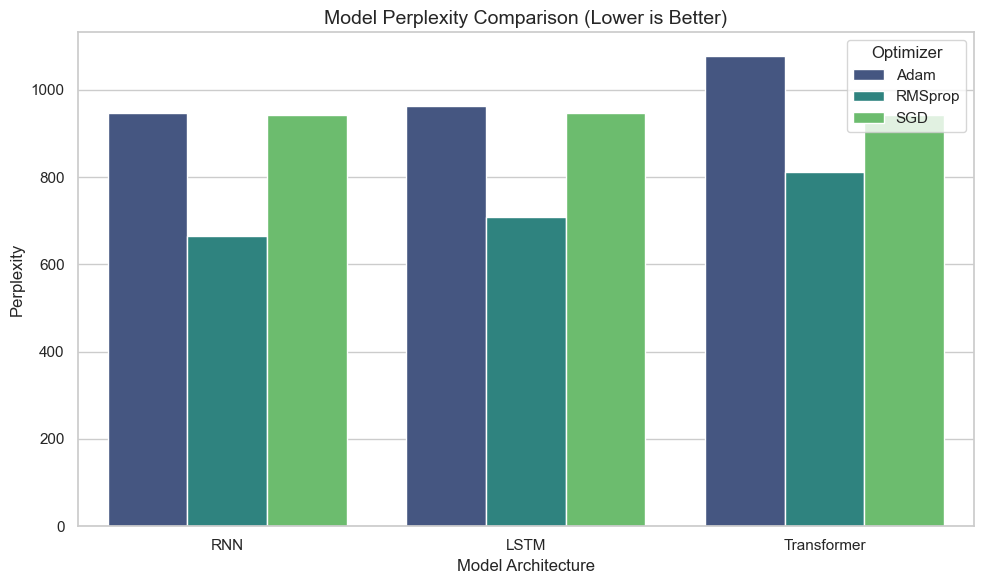

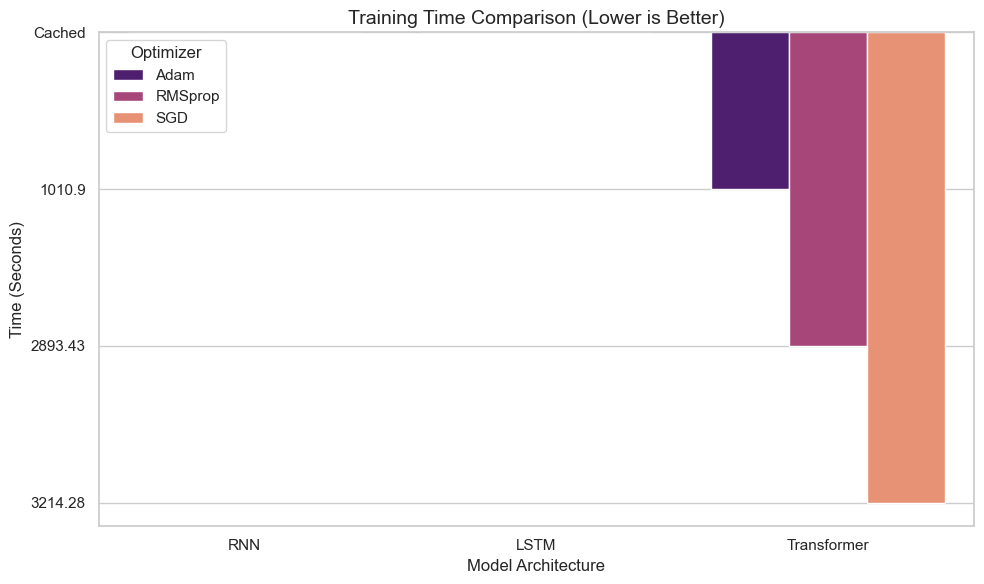

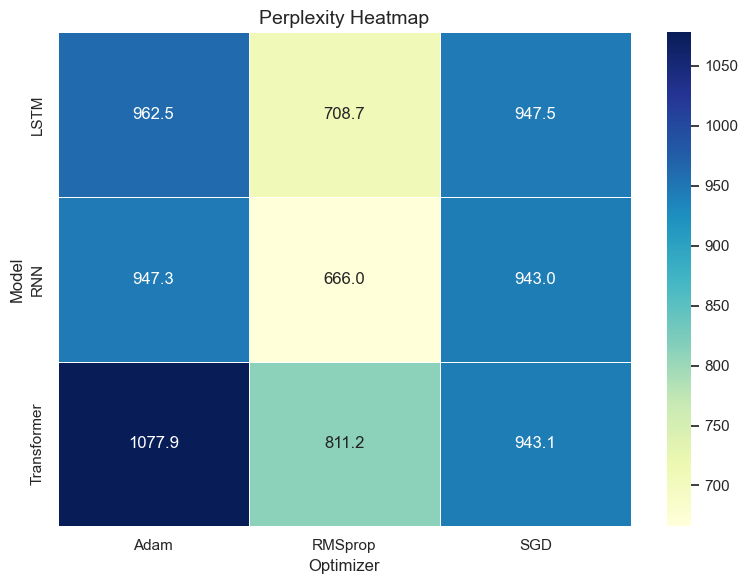


 Generating Loss Curves from Logs...


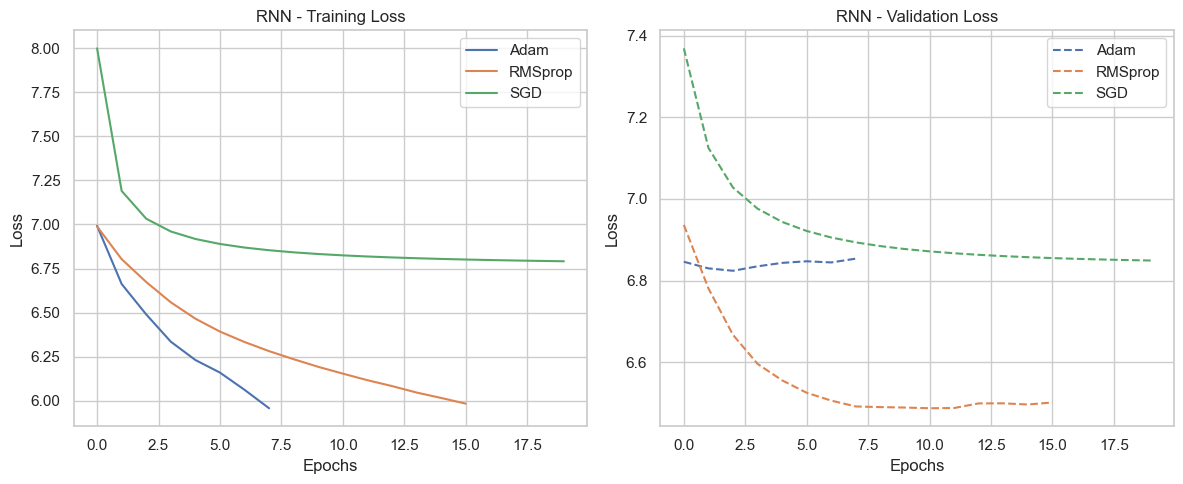

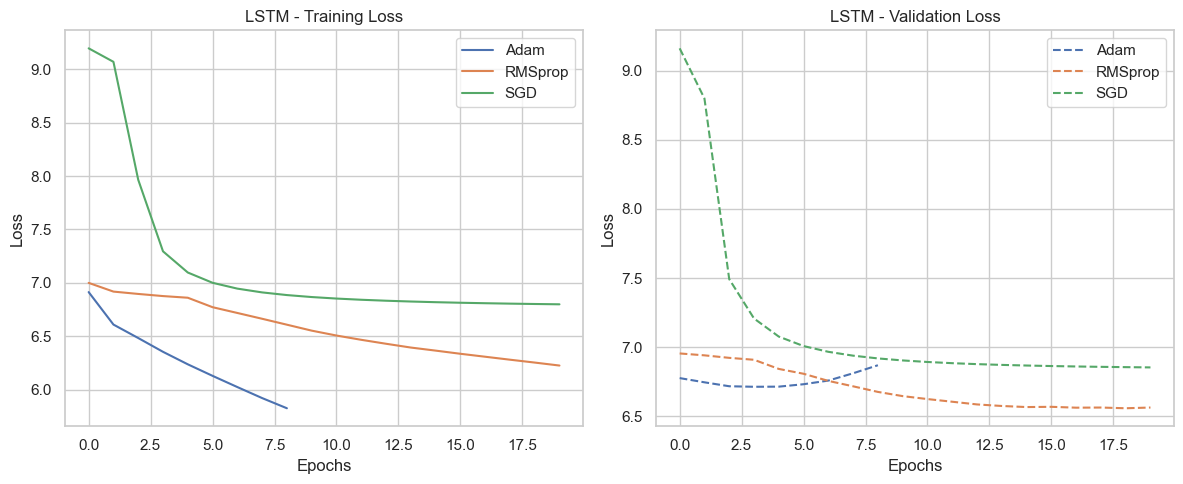

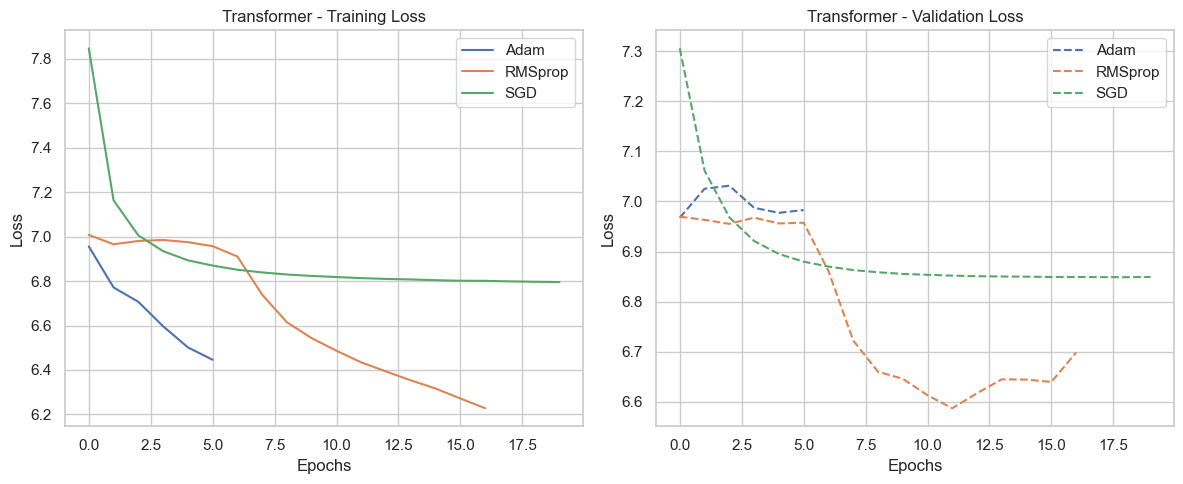


 Generating Hyperparameter Analysis Plots...


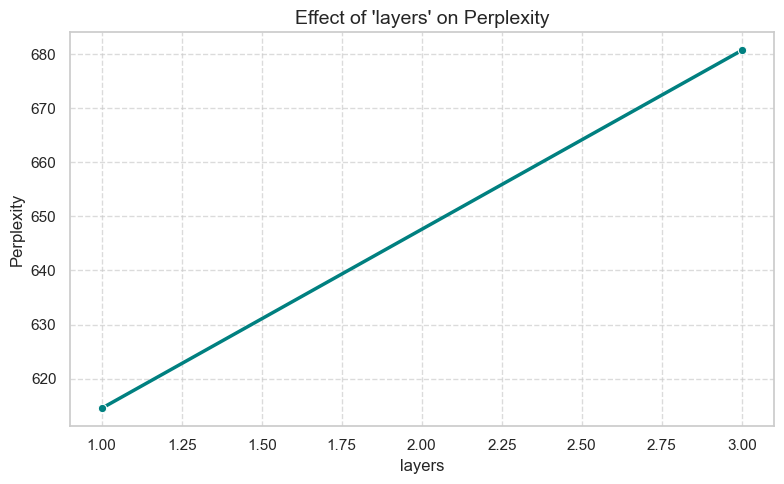

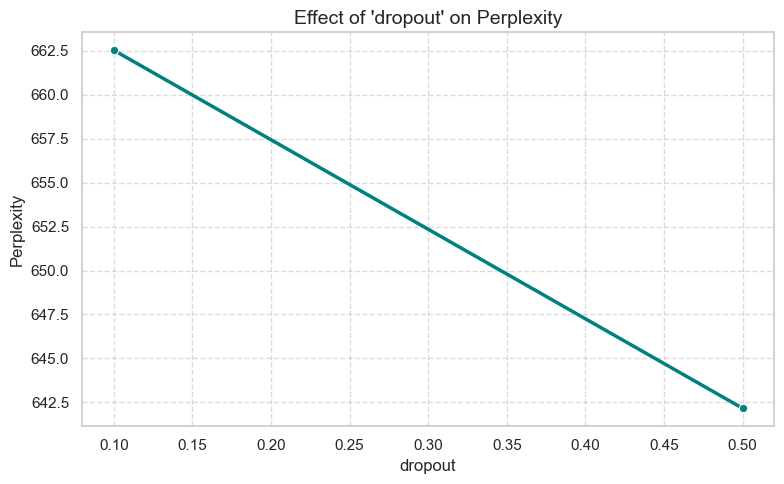

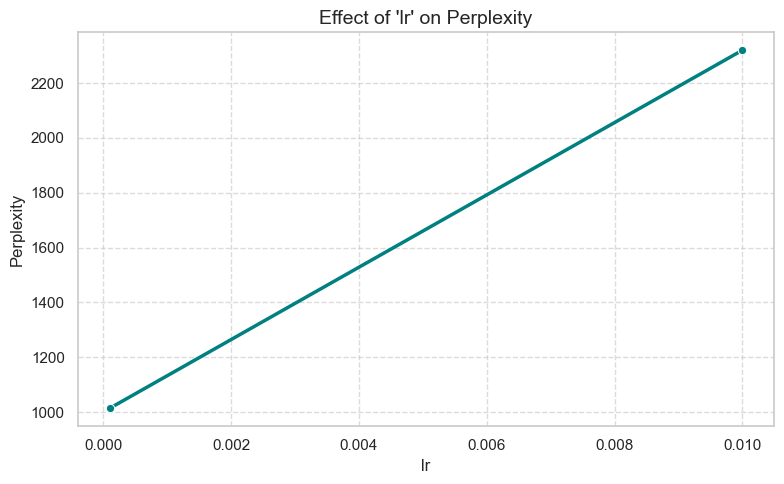

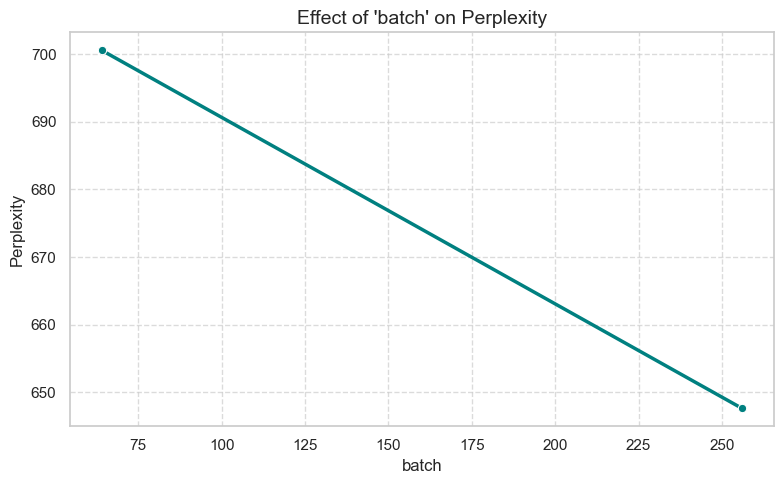

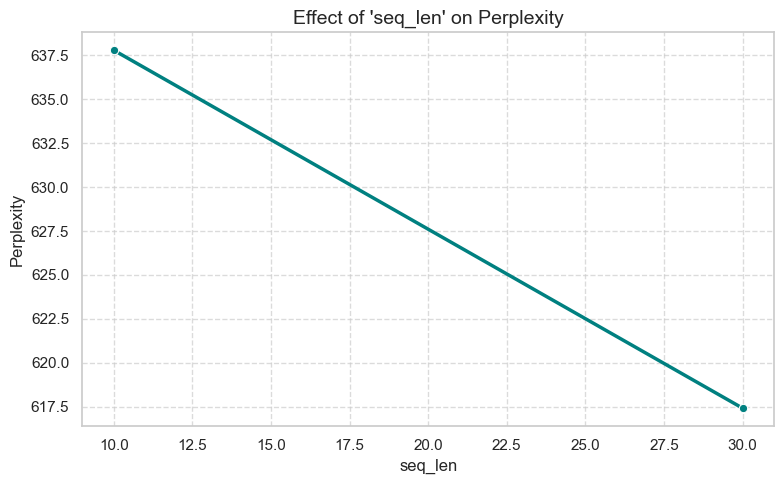

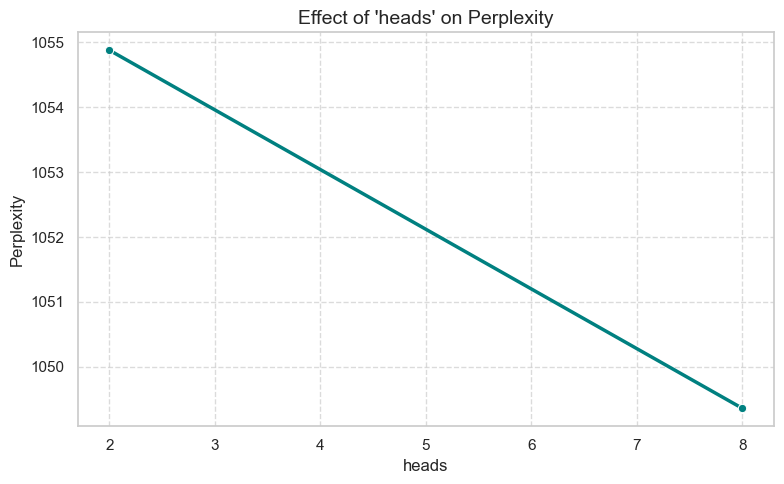

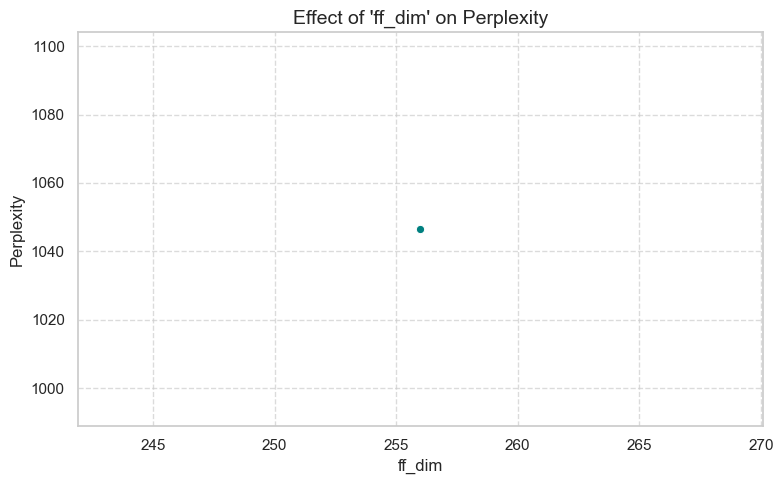

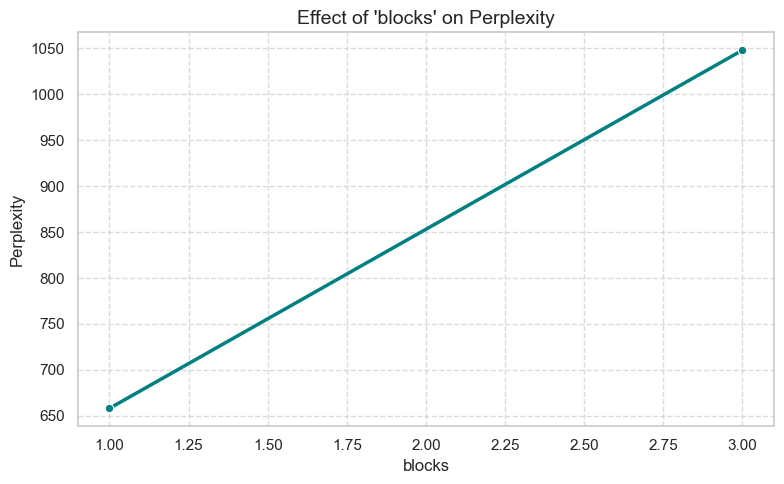


✅ All plots saved to ../results/plots/


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob


BASELINE_RESULTS_PATH = '../results/tables/optimizer_comparison_baseline.csv'
HYPERPARAM_RESULTS_PATH = '../results/tables/hyperparameter_results.csv'
LOGS_DIR = '../results/training_logs/'
SAVE_DIR = '../results/plots/'

os.makedirs(SAVE_DIR, exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

print(" Loading Data...")

# Loading Baseline Results 
if os.path.exists(BASELINE_RESULTS_PATH):
    df_baseline = pd.read_csv(BASELINE_RESULTS_PATH)
    print(f" Loaded Baseline Results: {len(df_baseline)} rows")
else:
    print(f" Warning: {BASELINE_RESULTS_PATH} not found. Skipping baseline plots.")
    df_baseline = pd.DataFrame()

# Loading Hyperparameter Results 
if os.path.exists(HYPERPARAM_RESULTS_PATH):
    df_hyper = pd.read_csv(HYPERPARAM_RESULTS_PATH)
    print(f" Loaded Hyperparameter Results: {len(df_hyper)} rows")
else:
    print(f" Warning: {HYPERPARAM_RESULTS_PATH} not found. Skipping hyperparam plots.")
    df_hyper = pd.DataFrame()


#Baseline Comparison Plots
if not df_baseline.empty:
    print("\n Generating Baseline Comparison Plots...")

    #  Perplexity Comparison Bar Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_baseline, x="Model", y="Perplexity", hue="Optimizer", palette="viridis")
    plt.title("Model Perplexity Comparison (Lower is Better)", fontsize=14)
    plt.ylabel("Perplexity")
    plt.xlabel("Model Architecture")
    plt.legend(title='Optimizer')
    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/perplexity_comparison.png", dpi=300)
    plt.show()

    #  Training Time Comparison Bar Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_baseline, x="Model", y="Training Time (s)", hue="Optimizer", palette="magma")
    plt.title("Training Time Comparison (Lower is Better)", fontsize=14)
    plt.ylabel("Time (Seconds)")
    plt.xlabel("Model Architecture")
    plt.legend(title='Optimizer')
    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/time_comparison.png", dpi=300)
    plt.show()

    #  Perplexity Heatmap
    # Pivot data for heatmap
    try:
        heatmap_data = df_baseline.pivot(index="Model", columns="Optimizer", values="Perplexity")
        plt.figure(figsize=(8, 6))
        sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
        plt.title("Perplexity Heatmap", fontsize=14)
        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/perplexity_heatmap.png", dpi=300)
        plt.show()
    except Exception as e:
        print(f"Could not generate heatmap: {e}")


#  Loss Curves from Logs
print("\n Generating Loss Curves from Logs...")

# Finding all log files
log_files = glob.glob(os.path.join(LOGS_DIR, "*_log.csv"))

if not log_files:
    print(" No log files found in directory.")
else:
    model_logs = {"RNN": [], "LSTM": [], "Transformer": []}
    
    for log_file in log_files:
        filename = os.path.basename(log_file)
        parts = filename.split('_')
        if len(parts) >= 2:
            model_name = parts[0]
            opt_name = parts[1]
            if model_name in model_logs:
                model_logs[model_name].append((opt_name, log_file))

    # Plot for each Model
    for model_name, logs in model_logs.items():
        if not logs:
            continue
            
        plt.figure(figsize=(12, 5))
        
        # Subplot 1: Training Loss
        plt.subplot(1, 2, 1)
        for opt_name, filepath in logs:
            try:
                df_log = pd.read_csv(filepath)
                plt.plot(df_log['loss'], label=f"{opt_name}")
            except: pass
        plt.title(f"{model_name} - Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        # Subplot 2: Validation Loss
        plt.subplot(1, 2, 2)
        for opt_name, filepath in logs:
            try:
                df_log = pd.read_csv(filepath)
                plt.plot(df_log['val_loss'], label=f"{opt_name}", linestyle="--")
            except: pass
        plt.title(f"{model_name} - Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/loss_curve_{model_name}.png", dpi=300)
        plt.show()


# Hyperparameter plots

if not df_hyper.empty:
    print("\n Generating Hyperparameter Analysis Plots...")
    
    # Get unique parameters tested
    params = df_hyper['Parameter'].unique()
    
    for param in params:
        subset = df_hyper[df_hyper['Parameter'] == param]
        
        plt.figure(figsize=(8, 5))
        
        # Check if 'Value' is numeric (Line Plot) or categorical (Bar Plot)
        is_numeric = pd.to_numeric(subset['Value'], errors='coerce').notnull().all()
        
        if is_numeric:
            # Sort by value for proper line plotting
            subset = subset.sort_values(by='Value')
            sns.lineplot(data=subset, x="Value", y="Perplexity", marker="o", linewidth=2.5, color='teal')
        else:
            sns.barplot(data=subset, x="Value", y="Perplexity", palette="ch:s=.25,rot=-.25")
            
        plt.title(f"Effect of '{param}' on Perplexity", fontsize=14)
        plt.xlabel(param)
        plt.ylabel("Perplexity")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/hyperparam_{param}.png", dpi=300)
        plt.show()

print(f"\n All plots saved to {SAVE_DIR}")